In [35]:
# Library Import
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Custom helper import
from helper.cadplot import conf_matrix
from helper.utils import log_results, plot_training_history,evaluate_model


In [36]:
# Trial run for mini dataset due to processing times.
trail_run = True

In [37]:
# Path Define
# File prefix name
_prefix = ''
_datapath="/Users/taiaburrahman/Desktop/Udg/CADx/Challenge/tf/"
# Set the path to your datasets
if trail_run:
    path = _datapath + "trial_dataset/binary/"
    _prefix = "trail_"
else:
    path = _datapath + "dataset/binary/"
    _prefix = "final_"

TRAIN_DATA_DIR = path + 'train'
VALIDATION_DATA_DIR = path + 'val'
TEST_DATA_DIR = path + 'testX'

In [38]:
# Set a random seed for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)


In [39]:
# Helper function

# Save model 
def model_save(model,file_path):
    model.save(file_path)


In [40]:
# Create a DataFrame for the test data
test_df = pd.DataFrame({'filename': os.listdir(TEST_DATA_DIR), 'class': None})
test_df['class'] = 0  # You can set a default class label for all test images (e.g., 0)


In [41]:
# Model Param setup
# Image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
# Batch size
batch_size = 32
# Iteration
EPOCHS = 20


In [42]:
# Use ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=90,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2  # 20% of the data will be used for validation
)
# Use ImageDataGenerator for testing without data augmentation
test_datagen = ImageDataGenerator(rescale=1.0/255)
# Create a data generator for training (with validation split)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary',
    subset='training'  # specify that this is the training set
)

# Create a data generator for validation (with validation split)
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary',
    subset='validation'  # specify that this is the validation set
)

test_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 82 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


In [43]:
prefix = _prefix + 'ResNet50_model'

# Load the pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional layers of ResNet50
for layer in resnet_model.layers:
    layer.trainable = False

# Create a new model with ResNet50 and additional layers for binary classification
resnet_custom_model = Sequential()
resnet_custom_model.add(resnet_model)
resnet_custom_model.add(Flatten())
resnet_custom_model.add(Dense(128, activation='relu'))
resnet_custom_model.add(Dense(1, activation='sigmoid'))

# Model summary
resnet_custom_model.summary()

# Compile the ResNet50 custom model
resnet_custom_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the ResNet50 custom model
start_time = time.time()

history_resnet_custom = resnet_custom_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

end_time = time.time()
# Save the VGG16 custom model (modify the saving path)
model_save(resnet_custom_model, f'model/{prefix}_model.h5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               12845184  
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36433025 (138.98 MB)
Trainable params: 12845313 (49.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Epoch 1/20


2023-12-13 09:26:49.313007: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


3/3 [==============================] - 5s 1s/step - loss: 16.2425 - accuracy: 0.5732 - val_loss: 17.1900 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 2s 776ms/step - loss: 7.5847 - accuracy: 0.5000 - val_loss: 5.4533 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 2s 576ms/step - loss: 10.1581 - accuracy: 0.5000 - val_loss: 17.8153 - val_accuracy: 0.5000
Epoch 4/20
3/3 [==============================] - 2s 540ms/step - loss: 19.1120 - accuracy: 0.5000 - val_loss: 21.0547 - val_accuracy: 0.5000
Epoch 5/20
3/3 [==============================] - 2s 590ms/step - loss: 20.4912 - accuracy: 0.5000 - val_loss: 18.4516 - val_accuracy: 0.5000
Epoch 6/20
3/3 [==============================] - 2s 778ms/step - loss: 16.0192 - accuracy: 0.5000 - val_loss: 11.8867 - val_accuracy: 0.5000
Epoch 7/20
3/3 [==============================] - 2s 619ms/step - loss: 9.1440 - accuracy: 0.5000 - val_loss: 2.9084 - val_accuracy: 0.5000
Epoch 8/20
3/3 [========

/Users/taiaburrahman/Desktop/Udg/CADx/Challenge/tf/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 3s 381ms/step
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


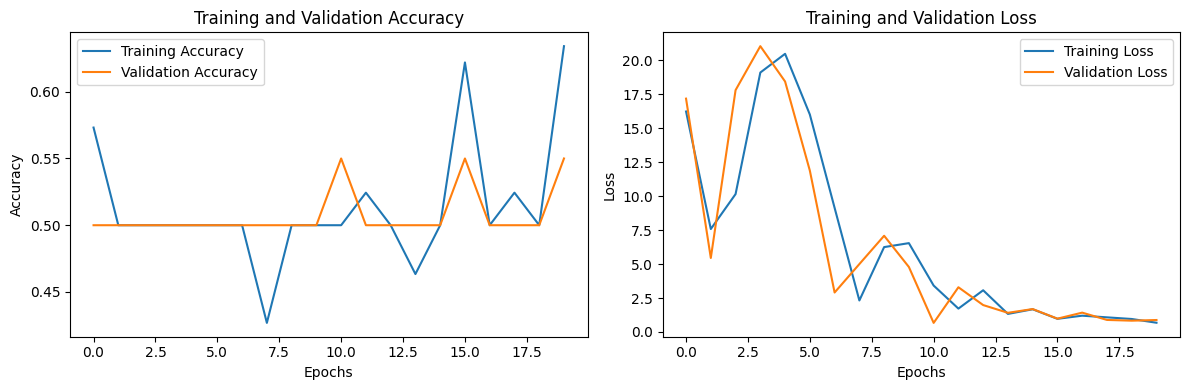

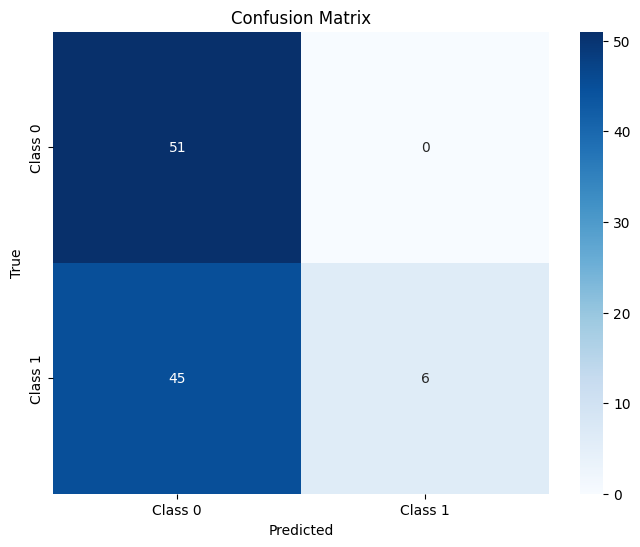

In [44]:
custom_model = resnet_custom_model
model_history = history_resnet_custom
# Assuming you have variables vgg16_custom_model and test_generator
test_loss, test_accuracy, conf_mat, classification_rep = evaluate_model(custom_model, test_generator)
# Assuming you have variables like start_time, end_time, test_accuracy, conf_mat, and classification_rep
log_results(prefix, start_time, end_time, test_accuracy, conf_mat, classification_rep)
print(model_history.history.keys())
# Assuming you have a variable model and prefix
plot_training_history(model_history, prefix)
# Create a heatmap for the confusion matrix
conf_matrix(conf_mat)